In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')
from plotly.offline import init_notebook_mode, iplot
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.tools as tls
import warnings
warnings.filterwarnings('ignore')
import re
import time
import networkx as nx
import plotly.express as px
from plotly.subplots import make_subplots

In [2]:
vehicle_col = pd.read_csv('Motor_Vehicle_Collisions_Crashes.csv')

In [3]:
vehicle_col.columns

Index(['CRASH DATE', 'CRASH TIME', 'BOROUGH', 'ZIP CODE', 'LATITUDE',
       'LONGITUDE', 'LOCATION', 'ON STREET NAME', 'CROSS STREET NAME',
       'OFF STREET NAME', 'NUMBER OF PERSONS INJURED',
       'NUMBER OF PERSONS KILLED', 'NUMBER OF PEDESTRIANS INJURED',
       'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED',
       'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST INJURED',
       'NUMBER OF MOTORIST KILLED', 'CONTRIBUTING FACTOR VEHICLE 1',
       'CONTRIBUTING FACTOR VEHICLE 2', 'CONTRIBUTING FACTOR VEHICLE 3',
       'CONTRIBUTING FACTOR VEHICLE 4', 'CONTRIBUTING FACTOR VEHICLE 5',
       'COLLISION_ID', 'VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2',
       'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5'],
      dtype='object')

In [4]:
vehicle_col['CRASH DATE'].max()

'12/31/2019'

In [5]:
vehicle_col['CRASH DATE'].min()

'01/01/2013'

In [6]:
vehicle_col.isnull().sum()

CRASH DATE                             0
CRASH TIME                             0
BOROUGH                           532863
ZIP CODE                          533073
LATITUDE                          206930
LONGITUDE                         206930
LOCATION                          206930
ON STREET NAME                    348507
CROSS STREET NAME                 606376
OFF STREET NAME                  1481998
NUMBER OF PERSONS INJURED             17
NUMBER OF PERSONS KILLED              31
NUMBER OF PEDESTRIANS INJURED          0
NUMBER OF PEDESTRIANS KILLED           0
NUMBER OF CYCLIST INJURED              0
NUMBER OF CYCLIST KILLED               0
NUMBER OF MOTORIST INJURED             0
NUMBER OF MOTORIST KILLED              0
CONTRIBUTING FACTOR VEHICLE 1       4830
CONTRIBUTING FACTOR VEHICLE 2     243483
CONTRIBUTING FACTOR VEHICLE 3    1622554
CONTRIBUTING FACTOR VEHICLE 4    1713445
CONTRIBUTING FACTOR VEHICLE 5    1731706
COLLISION_ID                           0
VEHICLE TYPE COD

In [7]:
#remove_cols = ['CONTRIBUTING FACTOR VEHICLE 3','CONTRIBUTING FACTOR VEHICLE 4','CONTRIBUTING FACTOR VEHICLE 5','VEHICLE TYPE CODE 3','VEHICLE TYPE CODE 4','VEHICLE TYPE CODE 5','ON STREET NAME','CROSS STREET NAME','OFF STREET NAME']

In [8]:
remove_cols = ['ON STREET NAME','CROSS STREET NAME','OFF STREET NAME']

In [9]:
vehicle_col = vehicle_col.drop(columns = remove_cols)

In [10]:
vehicle_col.shape

(1738137, 26)

In [11]:
vehicle_col.dropna(subset = ['LATITUDE', 'LONGITUDE'], inplace = True)

In [21]:
vehicle_col.dropna(subset = ['BOROUGH'], inplace = True)

In [13]:
###Datatype cleaning
vehicle_col['CRASH DATE'] = pd.to_datetime(vehicle_col['CRASH DATE'], format='%m/%d/%Y')

In [14]:
vehicle_col['CRASH TIME'] = pd.to_datetime(vehicle_col['CRASH TIME'], errors='coerce').dt.time

In [15]:
vehicle_col["YEAR"] = vehicle_col["CRASH DATE"].dt.year
vehicle_col["MONTH"] = vehicle_col["CRASH DATE"].dt.month
vehicle_col["DAY"] = vehicle_col["CRASH DATE"].dt.day
vehicle_col["WEEKDAY"] = vehicle_col["CRASH DATE"].dt.weekday

In [16]:
###Defining a function DONE


def getData():    
    ## Pulling the data ##
    df = pd.read_csv('Motor_Vehicle_Collisions_Crashes.csv')

    ## Formating the Date ##
    df['CRASH DATE'] = pd.to_datetime(df['CRASH DATE'], format='%m/%d/%Y')
    df = df.sort_values(by='CRASH DATE')
    
    ## Filtering the Desired Date Range - 2013 to 2016 ##
    df = df[df['CRASH DATE']>='01/01/2013']
    df = df[df['CRASH DATE']<'12/31/2019']
    df = df.reset_index(drop=True)

    return df

""" getFeatures() Function when called, returns a dataframe with additional features."""
def getFeatures(df):
    ## Takes unstructured Zip Code data [some are int and some are in string format] and formats them evenly##
    df['ZIP CODE'] = df['ZIP CODE'].apply(str)
    df['ZIP CODE'] = df['ZIP CODE'].str.split('.',expand=True)[0]
    
    ## Creating New Features using the Date Column ##
    df["YEAR"] = df["CRASH DATE"].dt.year
    df["MONTH"] = df["CRASH DATE"].dt.month
    df["DAY"] = df["CRASH DATE"].dt.day
    df["WEEKDAY"] = df["CRASH DATE"].dt.weekday
    df["TIME2"] = pd.to_datetime(df['CRASH TIME'], format='%H:%M')
    df["HOUR"] = df["TIME2"].dt.hour
    del df['TIME2']
    
    ## Based on Day, Month and Hour Features, We created additional features such as season, weekend, workhour etc. ##
    df["wdayStatus"]="Weekday"
    df["wdayStatus"].ix[df['DAY'] >4] = "Weekend"
    df["monthStatus"] = "Fall"
    df.loc[(df["MONTH"] < 3) | (df["MONTH"] >= 12), "monthStatus"]="Winter"
    df.loc[(df["MONTH"] < 6) & (df["MONTH"] >= 3), "monthStatus"]="Spring"
    df.loc[(df["MONTH"] < 9) & (df["MONTH"] >= 6), "monthStatus"]="Summer"
    
    df["hourStatus"] = "Evening"
    df.loc[(df["HOUR"] < 18) & (df["wdayStatus"] == "Weekday"), "hourStatus"]="WorkHour"
    df.loc[(df["HOUR"] < 7) & (df["wdayStatus"] == "Weekday"), "hourStatus"]="Night"
    df.loc[(df["HOUR"] < 16) & (df["wdayStatus"] == "Weekend"), "hourStatus"]="Day"
    df.loc[(df["HOUR"] < 7) & (df["wdayStatus"] == "Weekend"), "hourStatus"]="Night"
    
    df['TotalDeathsInjuries'] = df['NUMBER OF PERSONS INJURED']+df['NUMBER OF PERSONS KILLED']
    #del df['COLLISION_ID']
    
    ## Created this Column for Counting Purposes ##
    df['Ref'] = 1
    return df

In [17]:
vehicle_col = getData() ## loading the data

In [18]:
vehicle_col = getFeatures(vehicle_col) ##getting missing data info and plotting it

In [19]:
#vehicle_col = vehicle_col.to_csv('vehicle_col.csv')

In [20]:
vehicle_col['BOROUGH'].unique()

array(['MANHATTAN', nan, 'BROOKLYN', 'STATEN ISLAND', 'QUEENS', 'BRONX'],
      dtype=object)

In [22]:
vehicle_col.rename({'VEHICLE TYPE CODE 1':'VEHICLE_TYPE_CODE_1', 
                     'VEHICLE TYPE CODE 2':'VEHICLE_TYPE_CODE_2'}, axis='columns',inplace=True)

In [23]:
vehicle_col.rename({'VEHICLE TYPE CODE 3':'VEHICLE_TYPE_CODE_3', 
                     'VEHICLE TYPE CODE 4':'VEHICLE_TYPE_CODE_4'}, axis='columns',inplace=True)

In [24]:
vehicle_col.rename({'VEHICLE TYPE CODE 5':'VEHICLE_TYPE_CODE_5'}, axis='columns',inplace=True)

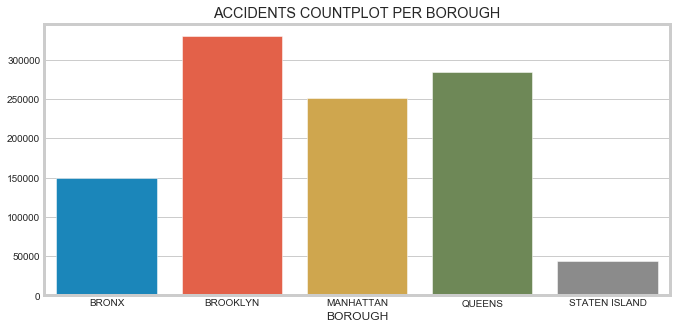

In [25]:
plt.figure(figsize=(10,5))
plt.title('ACCIDENTS COUNTPLOT PER BOROUGH')
sns.barplot(x=vehicle_col.groupby('BOROUGH').size().index,
            y=vehicle_col.groupby('BOROUGH').size().values)

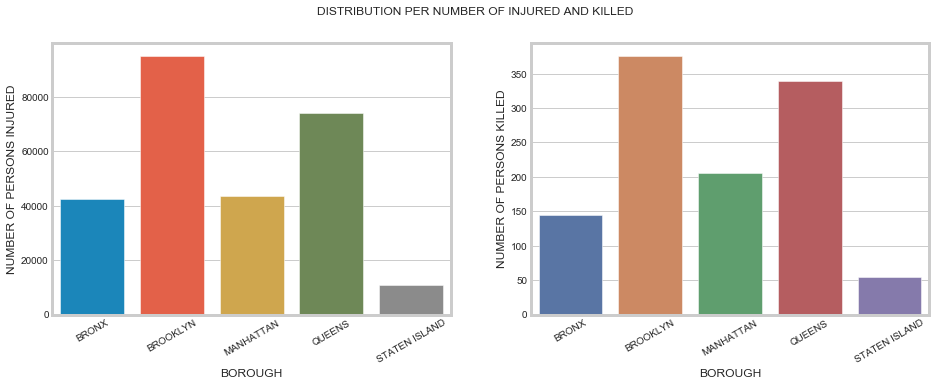

In [26]:
accidents_bor_df = vehicle_col.groupby('BOROUGH')[['NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED']].sum()

fig, ax = plt.subplots(1,2,figsize=(14,5))
plt.suptitle('DISTRIBUTION PER NUMBER OF INJURED AND KILLED')

ax[1].set_xticklabels(labels=accidents_bor_df.index,rotation=30)
ax[0].set_xticklabels(labels=accidents_bor_df.index,rotation=30)

sns.barplot(accidents_bor_df.index, accidents_bor_df['NUMBER OF PERSONS INJURED'], ax=ax[0])
sns.barplot(accidents_bor_df.index, accidents_bor_df['NUMBER OF PERSONS KILLED'], ax=ax[1], palette='deep')

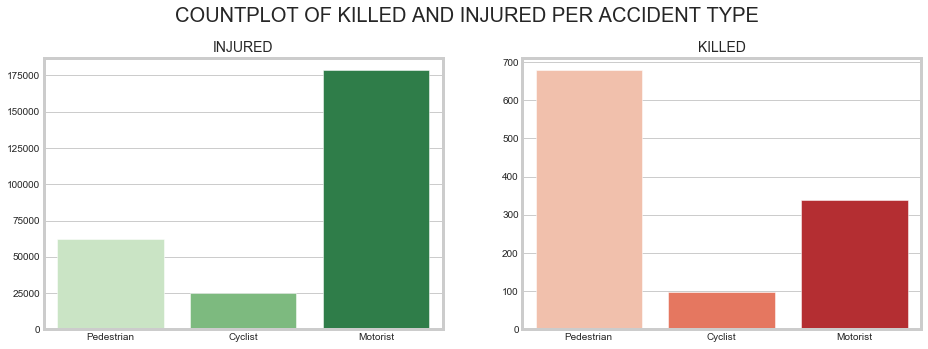

In [27]:
gr_injured = vehicle_col[[i for i in vehicle_col.columns for c in ['NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF CYCLIST INJURED', 'NUMBER OF MOTORIST INJURED'] if c in i]].sum()
gr_killed = vehicle_col[[i for i in vehicle_col.columns for c in ['NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST KILLED'] if c in i]].sum()
gr_injured.index = ['Pedestrian', 'Cyclist', 'Motorist']
gr_killed.index = ['Pedestrian', 'Cyclist', 'Motorist']

fig, ax = plt.subplots(1,2,figsize=(14,5))
plt.suptitle('COUNTPLOT OF KILLED AND INJURED PER ACCIDENT TYPE', fontsize=20, x=0.5,y=1.02)
ax[0].set_title('INJURED', fontsize=14)
ax[1].set_title('KILLED', fontsize=14)

sns.barplot(gr_injured.index, gr_injured.values, ax=ax[0], palette='Greens')
sns.barplot(gr_killed.index, gr_killed.values, ax=ax[1], palette='Reds')

In [28]:
### Trend of the Casualties over the years ###

fig = make_subplots(rows=3,cols=1,
                    subplot_titles=('PEDESTRIAN', 'CYCLIST', 'MOTORIST'))

feat_in  = ['NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF CYCLIST INJURED', 'NUMBER OF MOTORIST INJURED']

feat_killed = ['NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST KILLED']

for i, atype in enumerate(feat_in):
    data_per_acc = vehicle_col.groupby('CRASH DATE')[atype].sum()
    data_per_acc1 = vehicle_col.groupby('CRASH DATE')[feat_killed[i]].sum()
    
    fig.add_trace(go.Scatter(x=data_per_acc.index, y=data_per_acc.values, name='Injured'), row=i+1,col=1)
    fig.add_trace(go.Scatter(x=data_per_acc1.index, y=data_per_acc1.values, name='Killed'), row=i+1, col=1)

fig.update_layout(title='NUMBER OF KILLED AND INJURED PER ACCIDENT TYPE',template='plotly_dark', width=1000, height=1100)
fig.show()

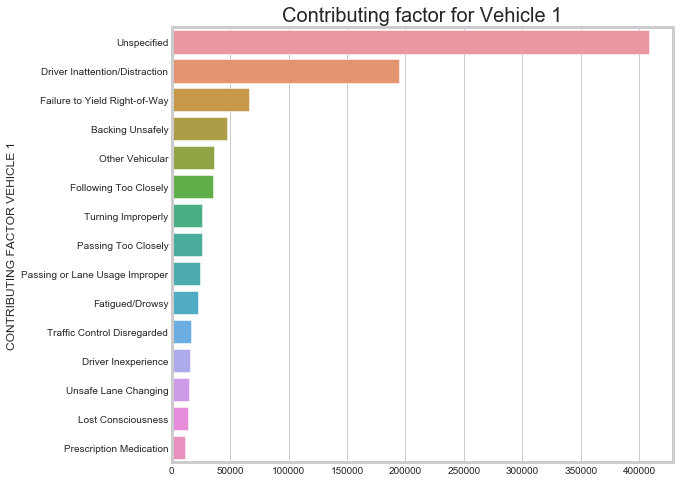

In [35]:
### Contributing factors for vehicle 1 ###

contri_df = vehicle_col.groupby('CONTRIBUTING FACTOR VEHICLE 1').size().sort_values(ascending=False).head(15)

plt.figure(figsize=(8,8))
plt.title('Contributing factor for Vehicle 1', fontsize=20)

sns.barplot(y = contri_df.index, x = contri_df.values)

In [57]:
### Weekly collisions by hour ###

#Data Preparation for the weekly analysis
#get count of collisions every hour on every weekday.

sunday = vehicle_col[vehicle_col['WEEKDAY'] == 6]
df_sundayhourlytripcount = sunday.groupby('HOUR').count()
monday = vehicle_col[vehicle_col['WEEKDAY'] == 0]
df_mondayhourlytripcount = monday.groupby('HOUR').count()
tuesday = vehicle_col[vehicle_col['WEEKDAY'] == 1]
df_tuesdayhourlytripcount = tuesday.groupby('HOUR').count()
wednesday = vehicle_col[vehicle_col['WEEKDAY'] == 2]
df_wednesdayhourlytripcount = wednesday.groupby('HOUR').count()
thursday =  vehicle_col[ vehicle_col['WEEKDAY'] == 3]
df_thursdayhourlytripcount = thursday.groupby('HOUR').count()
friday = vehicle_col[vehicle_col['WEEKDAY'] == 4]
df_fridayhourlytripcount = friday.groupby('HOUR').count()
saturday = vehicle_col[vehicle_col['WEEKDAY'] == 5]
df_saturdayhourlytripcount = saturday.groupby('HOUR').count()
collisions_hr_x = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
sun_crashcounty = df_sundayhourlytripcount['CRASH TIME']
mon_crashcounty = df_mondayhourlytripcount['CRASH TIME']
tues_crashcounty = df_tuesdayhourlytripcount['CRASH TIME']
wed_crashcounty = df_wednesdayhourlytripcount['CRASH TIME']
thurs_crashcounty = df_thursdayhourlytripcount['CRASH TIME']
fri_crashcounty = df_fridayhourlytripcount['CRASH TIME']
sat_crashcounty = df_saturdayhourlytripcount['CRASH TIME']

df_sundayhourlytripcount.tail(1)
sun_crashcounty.tail(1)

# Create traces
trace1 = go.Scatter(x = collisions_hr_x, y = sun_crashcounty,  mode = "lines+markers", name = 'Sunday')
trace2 = go.Scatter(x = collisions_hr_x, y = mon_crashcounty, name = 'Monday')
trace3 = go.Scatter( x = collisions_hr_x, y = tues_crashcounty, name = 'Tuesday')
trace4 = go.Scatter( x = collisions_hr_x, y = wed_crashcounty, name = 'Wednesday')
trace5 = go.Scatter( x = collisions_hr_x, y = thurs_crashcounty,  name = 'Thursday')
trace6 = go.Scatter( x = collisions_hr_x, y = fri_crashcounty,   name = 'Friday')
trace7 = go.Scatter(x =collisions_hr_x, y = sat_crashcounty,  mode = "lines+markers", name = 'Saturday')

layout = dict(title = 'Weekly Collisions by Hour', 
              xaxis= dict(title= 'Hour of the day',ticklen= 5,zeroline= False),
              yaxis= dict(title= 'Collisions quantity',ticklen= 5,zeroline= False)
             )
linedata = [trace1, trace2, trace3, trace4, trace5, trace6,trace7]
fig = dict(data=linedata, layout=layout)
py.iplot(fig)

In [37]:
### Trend over the hours and weekdays ### 

#Preparing data for the graph
W_0 = vehicle_col[vehicle_col['WEEKDAY'] == 0].groupby('HOUR').count()
W_1 = vehicle_col[vehicle_col['WEEKDAY'] == 1].groupby('HOUR').count()
W_2 = vehicle_col[vehicle_col['WEEKDAY'] == 2].groupby('HOUR').count()
W_3 = vehicle_col[vehicle_col['WEEKDAY'] == 3].groupby('HOUR').count()
W_4 = vehicle_col[vehicle_col['WEEKDAY'] == 4].groupby('HOUR').count()
W_5 = vehicle_col[vehicle_col['WEEKDAY'] == 5].groupby('HOUR').count()
W_6 = vehicle_col[vehicle_col['WEEKDAY'] == 6].groupby('HOUR').count()

#W_0.head()
trace = go.Heatmap(z=[W_0['CRASH TIME'],W_1['CRASH TIME'],W_2['CRASH TIME'],W_3['CRASH TIME'],W_4['CRASH TIME'],W_5['CRASH TIME'],W_6['CRASH TIME']],
                    y=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday'],
                   x=['Midnight','1am','2am','3am','4am','5am','6am','7am','8am','9am','10am','11am','Noon','1pm','2pm',
                     '3pm','4pm','5pm','6pm','7pm','8pm','9pm','10pm','11pm'],
                  colorscale='Reds',xgap = 10,ygap = 10,)

layout = dict(title = 'Collisions per week per hour')
dataheat=[trace]
fig = dict(data = dataheat, layout=layout)
py.iplot(fig, filename='labelled-heatmap')

Number of collisions reported:  1058016
Number of accidents with (at least) one injury :  200078
Number of accidents with (at least) one fatality :  1085


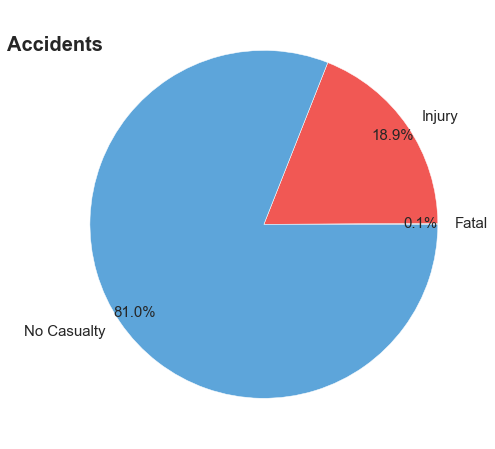

In [38]:
### Collision's severity ###

N_collision = len(vehicle_col)
print("Number of collisions reported: ", N_collision)

df_injury = vehicle_col[(vehicle_col['NUMBER OF PERSONS INJURED'] > 0)].copy()

# store the number of collisions with injury in N_injury
N_injury = len(df_injury)
print('Number of accidents with (at least) one injury : ', N_injury)

df_fatal = vehicle_col[(vehicle_col['NUMBER OF PERSONS KILLED'] > 0)].copy()

# store the number of collisions with death in N_fatal
N_fatal = len(df_fatal)
print('Number of accidents with (at least) one fatality : ', N_fatal)


fig, ax = plt.subplots(figsize = (8,8))

labels = 'Fatal', 'Injury', 'No Casualty'
fracs = [N_fatal, N_injury, N_collision - N_fatal - N_injury]

ax.pie(fracs,  labels=labels, autopct='%1.1f%%',pctdistance= 0.9, 
        colors=['#4D4D4D', '#F15854','#5DA5DA' ],textprops = {'fontsize' : 15});

plt.text(-1.2,1,'Accidents',fontsize = 20, ha = 'center', weight = 'bold');
fig.savefig('severity.jpg', transparent=True, bbox_inches='tight')

Text(0.5, 1.0, 'Total % of Traffic Accidents by Borough in NYC')

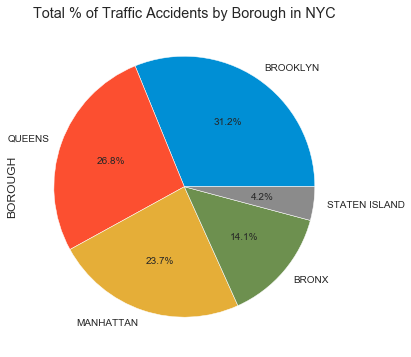

In [39]:
### Proportion of accidents by borough ###

vehicle_col['BOROUGH'].value_counts().plot(kind = 'pie',autopct='%1.1f%%',figsize=(6,6))
plt.title('Total % of Traffic Accidents by Borough in NYC')

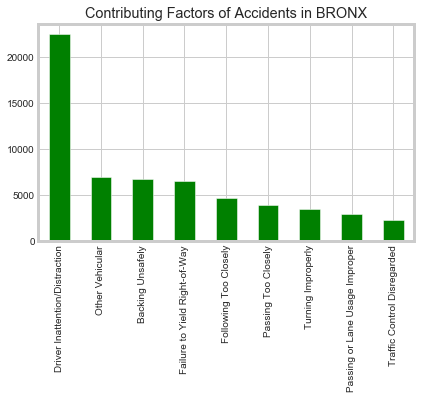

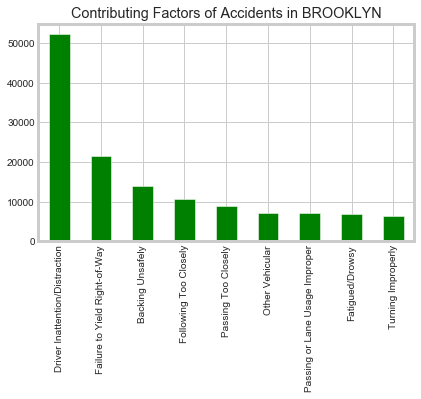

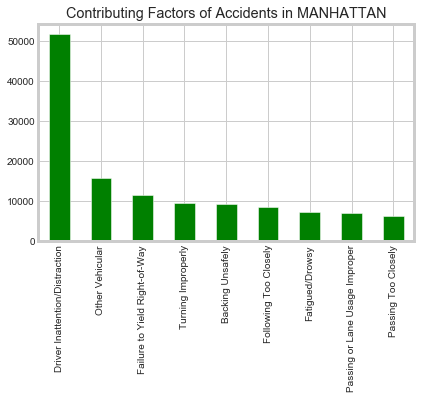

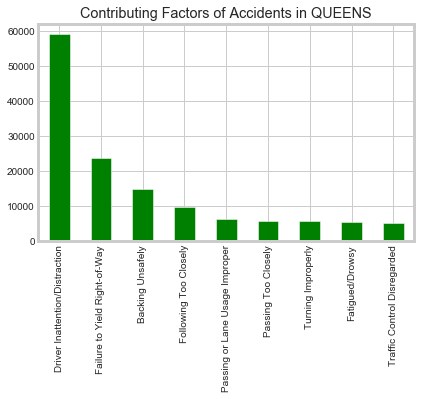

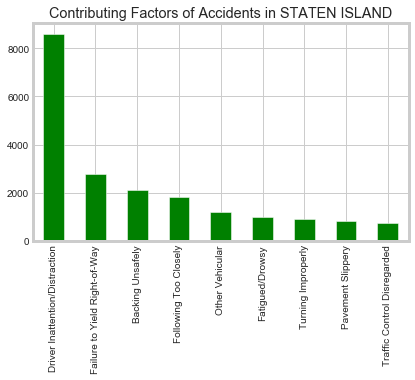

In [40]:
### Contributing factors for the collisions by Boroughs ###

crimeByArea = vehicle_col['BOROUGH'].value_counts().sort_index()
crimeCommonType = {} # This dictionary is for later
for area in crimeByArea.keys():
    crimeArea = vehicle_col[vehicle_col['BOROUGH'] == area]['CONTRIBUTING FACTOR VEHICLE 1'].value_counts()[1:10]
    for crType in crimeArea.keys():
        if not crType in crimeCommonType:
            crimeCommonType[crType] = [area]
        else:
            crimeCommonType[crType].append(area)
    crimeArea = crimeArea.plot(kind = 'bar',title = "Contributing Factors of Accidents in " + area, color = 'green')
    plt.show()

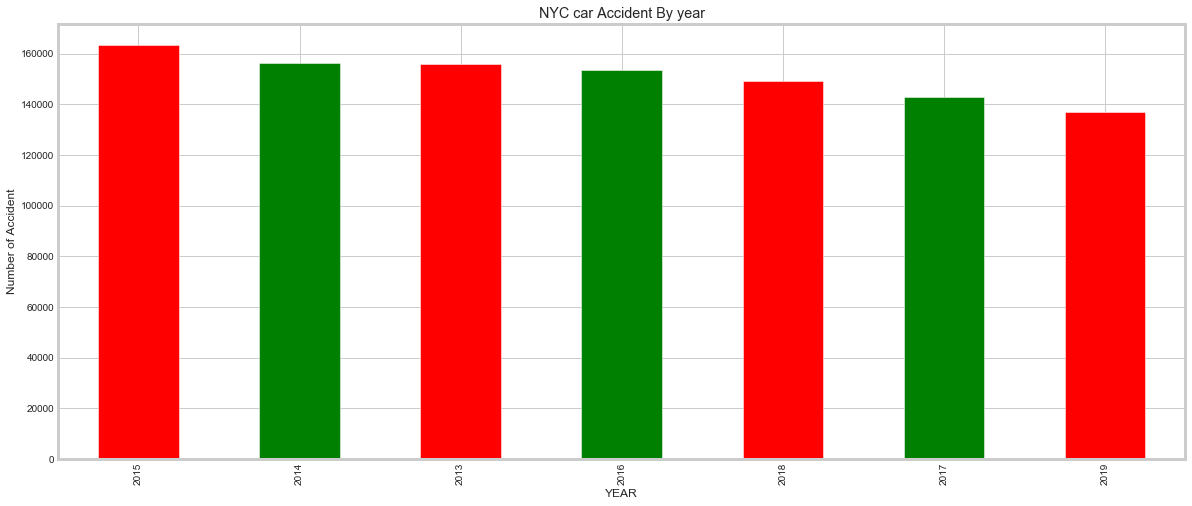

In [41]:
pd.value_counts(vehicle_col['YEAR']).plot.bar(color=['red','green'])
plt.xlabel('YEAR')
plt.ylabel('Number of Accident')
plt.title('NYC car Accident By year')
plt.gcf().set_size_inches(18, 8)
plt.show()

In [42]:
vehicle_col['VEHICLE_TYPE_CODE_1'].fillna('unknown',inplace=True)
vehicle_col['VEHICLE_TYPE_CODE_2'].fillna('unknown',inplace=True)
vehicle_col['VEHICLE_TYPE_CODE_3'].fillna('unknown',inplace=True)
vehicle_col['VEHICLE_TYPE_CODE_4'].fillna('unknown',inplace=True)
vehicle_col['VEHICLE_TYPE_CODE_5'].fillna('unknown',inplace=True)

vehicle_col['VEHICLE_TYPE_CODE_1'] = vehicle_col['VEHICLE_TYPE_CODE_1'].str.lower()
vehicle_col['VEHICLE_TYPE_CODE_2'] = vehicle_col['VEHICLE_TYPE_CODE_2'].str.lower()
vehicle_col['VEHICLE_TYPE_CODE_3'] = vehicle_col['VEHICLE_TYPE_CODE_3'].str.lower()
vehicle_col['VEHICLE_TYPE_CODE_4'] = vehicle_col['VEHICLE_TYPE_CODE_4'].str.lower()
vehicle_col['VEHICLE_TYPE_CODE_5'] = vehicle_col['VEHICLE_TYPE_CODE_5'].str.lower()

In [43]:
for i in range(5):
    feat = 'VEHICLE_TYPE_CODE_'+str(i+1)
    print("Number of values for ",feat, " = ",len(vehicle_col[feat].unique()))

Number of values for  VEHICLE_TYPE_CODE_1  =  540
Number of values for  VEHICLE_TYPE_CODE_2  =  582
Number of values for  VEHICLE_TYPE_CODE_3  =  98
Number of values for  VEHICLE_TYPE_CODE_4  =  44
Number of values for  VEHICLE_TYPE_CODE_5  =  33


In [44]:
### Data Cleaning ###

values_lst = []

for i in range(5):
    feat = 'VEHICLE_TYPE_CODE_'+str(i+1)
    values = vehicle_col.groupby(feat).size().sort_values(ascending = False)
    
    values = values[values > 10000]
    values_lst.append(str(values))
    print("")
    print(values)

v1 = set(vehicle_col['VEHICLE_TYPE_CODE_1'])
v2 = set(vehicle_col['VEHICLE_TYPE_CODE_2'])
v3 = set(vehicle_col['VEHICLE_TYPE_CODE_3'])
v4 = set(vehicle_col['VEHICLE_TYPE_CODE_4'])
v5 = set(vehicle_col['VEHICLE_TYPE_CODE_5'])

print("Number of distinct values:", len(v1|v2|v3|v4|v5))
babidi = list(v1|v2|v3|v4|v5)

pat = r'(bike)|(bicycle)|(nyc b)|(pedic)|bik|eb|elect' 
replacement = 'Bike'
for i in range(5):
    feat = 'VEHICLE_TYPE_CODE_'+str(i+1)
    vehicle_col[feat] = vehicle_col[feat].apply(lambda x: replacement if re.match(pat,x) else x)


pat =(r"(box)|(cemen)|(cm)|(co)|(cargo)|(carr)|(delv)|(deliv)|(dump)|(elect)|(fire)|(freig)|(garba)|(ice)|(large)|"
        "(liver)|(p[i]*[c]*k)|(ref)|(tk)|(tow)|(tr)|(tt)|(tank)|(tru)|(trac)|(trail)|(trans)|(trl)|(semi)|(ups t)")
replacement = 'Truck'
for i in range(5):
    feat = 'VEHICLE_TYPE_CODE_'+str(i+1)
    vehicle_col[feat] = vehicle_col[feat].apply(lambda x: replacement if re.match(pat,x) else x)



pat = r'(schoo)|(bu)|(flat)|(fb)|(mta b)|(rv)|(omni)'# probably flat and fb refers to a specific type of bus (flat bus)
replacement = 'Bus'
for i in range(5):
    feat = 'VEHICLE_TYPE_CODE_'+str(i+1)
    vehicle_col[feat] = vehicle_col[feat].apply(lambda x: replacement if re.match(pat,x) else x)


pat = r'(mb)|(moped)|(motor)|(scoot)'
replacement = 'Motorcycle'
for i in range(5):
    feat = 'VEHICLE_TYPE_CODE_'+str(i+1)
    vehicle_col[feat] = vehicle_col[feat].apply(lambda x: replacement if re.match(pat,x) else x)


pat = r'(pas)|(p/)|(sedan)|(renta)|(small)|(sub)|(station)|(sport)|(suv)|(util)|(wagon)'
replacement = 'Passenger Vehicle'
for i in range(5):
    feat = 'VEHICLE_TYPE_CODE_'+str(i+1)
    vehicle_col[feat] = vehicle_col[feat].apply(lambda x: replacement if re.match(pat,x) else x)


VEHICLE_TYPE_CODE_1
passenger vehicle                      266435
sedan                                  235373
station wagon/sport utility vehicle    186773
sport utility / station wagon          118474
taxi                                    50353
4 dr sedan                              26746
pick-up truck                           23087
van                                     22558
bus                                     20218
unknown                                 19692
other                                   16016
box truck                               11322
dtype: int64

VEHICLE_TYPE_CODE_2
unknown                                231920
passenger vehicle                      200140
sedan                                  170983
station wagon/sport utility vehicle    141170
sport utility / station wagon           90742
taxi                                    41816
pick-up truck                           21382
van                                     20282
4 dr sedan               

In [45]:
### Pie Chart preparation ###

vehicles = ['Bike', 'Truck', 'Motorcycle',  'Passenger Vehicle', 'Bus','taxi']
N_vehicles = []


for v in vehicles:
    N = 0
    for i in range(5):
        feat = 'VEHICLE_TYPE_CODE_'+str(i+1)
        N += (vehicle_col[feat] == v).sum()
    N_vehicles.append(N)
    
    print('Number of '+v+' = ', N)

N = 0
for i in range(5):
    feat = 'VEHICLE_TYPE_CODE_'+str(i+1)
    N += (vehicle_col[feat].apply(lambda x: True if x not in (vehicles + ['unknown']) else False)).sum()
vehicles.append('other')
N_vehicles.append(N)
print("Number of Others", N)

Number of Bike =  33079
Number of Truck =  127225
Number of Motorcycle =  12230
Number of Passenger Vehicle =  1490733
Number of Bus =  40562
Number of taxi =  93858
Number of Others 137878


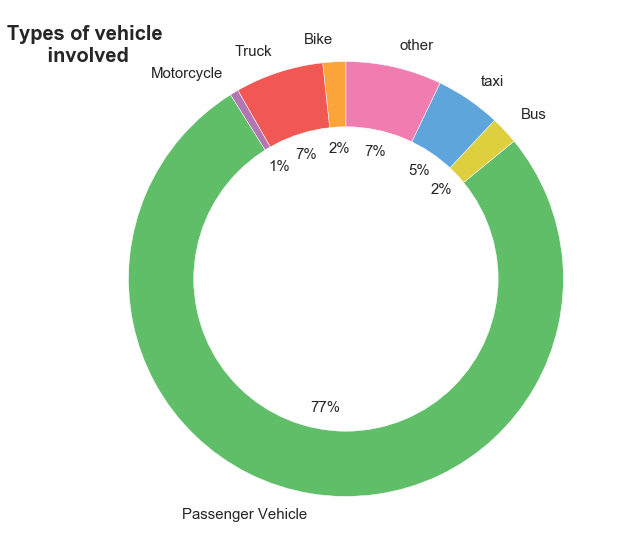

In [46]:
### Types of vehicles involved in the collisons ###

fig1, ax1 = plt.subplots(figsize = (10,10))

explode = np.zeros(len(vehicles))
ax1.pie(N_vehicles,labels=vehicles, autopct='%1.0f%%', explode = explode ,
        colors = ['#FAA43A','#F15854', '#B276B2','#60BD68', '#DECF3F', '#5DA5DA','#F17CB0'],
        startangle=90, textprops = {'fontsize': 15})

#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
#ax1.axis('equal')  
#plt.tight_layout()
plt.text(-1.2,1,'Types of vehicle\n involved',fontsize = 20, ha = 'center', weight = 'bold');
#plt.title('Type of vehicles involved',fontsize = 20, ha = 'center',weight = 'bold');
fig.savefig('vehicles.png', transparent=True, bbox_inches='tight')

In [47]:
# count number of motorist, cyclist and pedestrian injured and killed

mot_injured = vehicle_col['NUMBER OF MOTORIST INJURED'].sum()
cyc_injured = vehicle_col['NUMBER OF CYCLIST INJURED'].sum()
ped_injured = vehicle_col['NUMBER OF PEDESTRIANS INJURED'].sum()

mot_killed = vehicle_col['NUMBER OF MOTORIST KILLED'].sum()
cyc_killed = vehicle_col['NUMBER OF CYCLIST KILLED'].sum()
ped_killed = vehicle_col['NUMBER OF PEDESTRIANS KILLED'].sum()

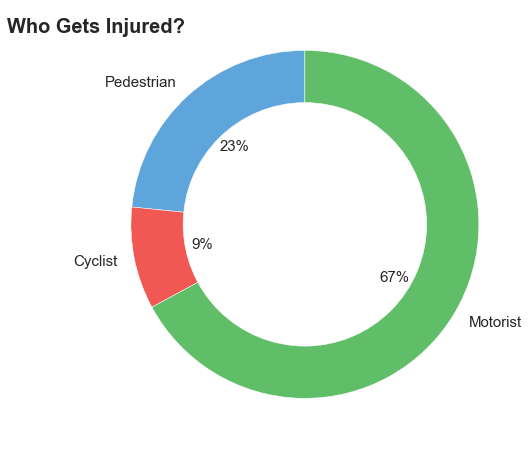

In [48]:
### Who gets injured? ###

fig1, ax1 = plt.subplots(figsize = (8,8))

who_injured = [ped_injured,cyc_injured,mot_injured]
labels = ['Pedestrian', 'Cyclist', 'Motorist']


ax1.pie(who_injured,labels=labels, autopct='%1.0f%%',
        colors = ['#5DA5DA','#F15854','#60BD68'],
        startangle=90, textprops = {'fontsize': 15})

#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# add text
plt.text(-1.2,1.1,'Who Gets Injured?',fontsize = 20, ha = 'center', weight = 'bold');


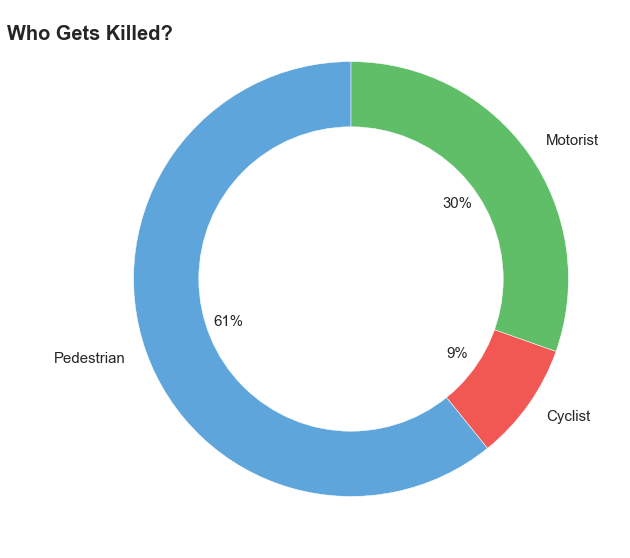

In [49]:
### Who gets killed? ###

fig1, ax1 = plt.subplots(figsize = (10,10))

who_killed = [ped_killed,cyc_killed,mot_killed]
labels = ['Pedestrian', 'Cyclist', 'Motorist']
ax1.pie(who_killed,labels=labels, autopct='%1.0f%%',
        colors = ['#5DA5DA','#F15854','#60BD68'],
        startangle=90, textprops = {'fontsize': 15})

#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# add text
plt.text(-1.2,1.1,'Who Gets Killed?',fontsize = 20, ha = 'center', weight = 'bold');
#plt.title('Type of vehicles involved',fontsize = 20, ha = 'center',weight = 'bold');


In [50]:
borough_injuries_month = vehicle_col.groupby([vehicle_col.MONTH, vehicle_col.BOROUGH])['NUMBER OF PEDESTRIANS INJURED'].sum().unstack()

In [51]:
borough_by_biggest_population = ['MANHATTAN', 'BROOKLYN', 'QUEENS', 'BRONX', 'STATEN ISLAND']
borough_injuries_month = borough_injuries_month[borough_by_biggest_population]

In [52]:
### Monthly statistics by the borough ###

months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
months_abbr = [m[:3] for m in months]

borough_injuries_month.index = months
borough_injuries_month

BOROUGH    MANHATTAN  BROOKLYN  QUEENS  BRONX  STATEN ISLAND
January         1399      2037    1465    879            178
February        1303      1604    1147    784            150
March           1290      1790    1220    883            124
April           1152      1554    1046    761            115
May             1275      1771    1119    854            146
June            1165      1694    1042    832            130
July            1093      1450     897    737            120
August          1084      1459     918    725             96
September       1125      1574    1080    780            117
October         1302      1933    1413    907            153
November        1260      1980    1525    945            161
December        1429      2231    1695   1009            162

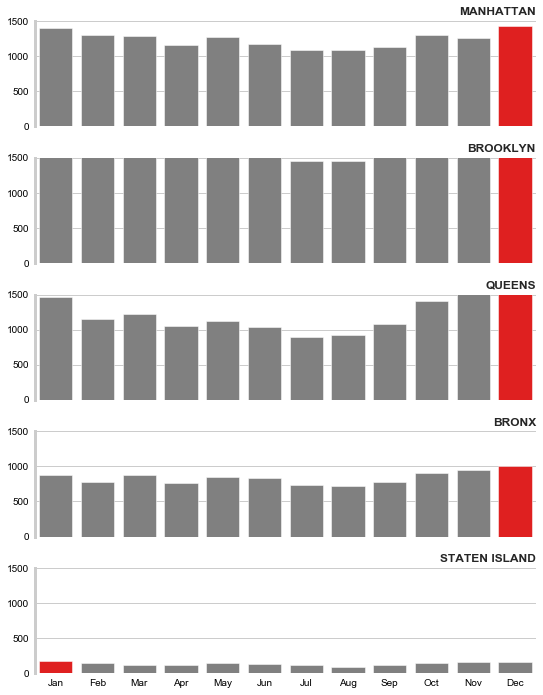

In [53]:
### Monthly trends by the borough ###

# Set up the matplotlib figure
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(8, 12), sharex=True, sharey=True)
f.subplots_adjust(hspace=.3)

for boro, ax in zip(borough_injuries_month, [ax1, ax2, ax3, ax4, ax5]):
    values = borough_injuries_month[boro].values
    colors = ['gray' if (x < max(values)) else 'red' for x in values]
    sns.barplot(months_abbr, borough_injuries_month[boro], palette=colors, ax=ax)
    ax.set_title(boro, loc='right', weight='bold', fontdict={'fontsize': 12})
    ax.set_ylabel('')
    ax.tick_params(direction='inout', length=4, width=1, colors='black')
    sns.despine(bottom=True)

plt.ylim(0, 1500)
plt.show();

In [54]:
year = vehicle_col[['NUMBER OF PERSONS INJURED',
       'NUMBER OF PERSONS KILLED', 'NUMBER OF PEDESTRIANS INJURED',
       'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED',
       'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST INJURED',
                    'NUMBER OF MOTORIST KILLED','YEAR']]

In [55]:
### Casualties over the year in the collisions ###

year.groupby('YEAR').sum()

NUMBER OF PERSONS INJURED  NUMBER OF PERSONS KILLED  \
YEAR                                                        
2013                    42052.0                     213.0   
2014                    38648.0                     183.0   
2015                    37834.0                     178.0   
2016                    38150.0                     130.0   
2017                    35193.0                     138.0   
2018                    37081.0                     139.0   
2019                    37195.0                     139.0   

      NUMBER OF PEDESTRIANS INJURED  NUMBER OF PEDESTRIANS KILLED  \
YEAR                                                                
2013                          10767                           132   
2014                           9861                           108   
2015                           8928                           105   
2016                           8650                            86   
2017                           7950                            78   
2018                           8209                            79   
2019                           7904                            90   

      NUMBER OF CYCLIST INJURED  NUMBER OF CYCLIST KILLED  \
YEAR                                                        
2013                       3721                         8   
2014                       3674                        16   
2015                       3862                        15   
2016                       3662                        12   
2017                       3351                        20   
2018                       3393                         6   
2019                       3580                        21   

      NUMBER OF MOTORIST INJURED  NUMBER OF MOTORIST KILLED  
YEAR                                                         
2013                       27564                         73  
2014                       25109                         59  
2015                       25043                         58  
2016                       25689                         27  
2017                       23895                         41  
2018                       25471                         53  
2019                       25710                         28

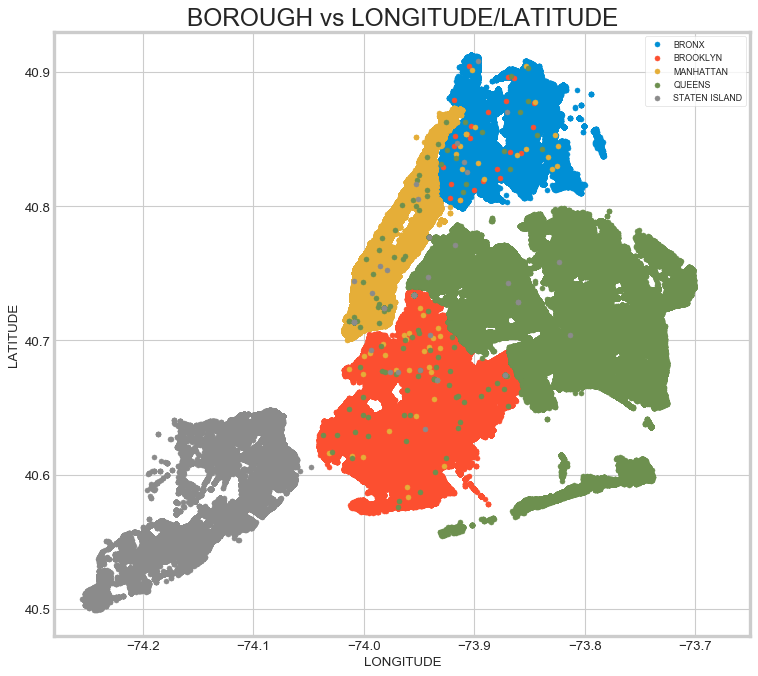

In [56]:
### NYC map for reference by latitude/longitude and borough ###

BOROUGHs = np.unique(vehicle_col['BOROUGH'])
colors = [plt.cm.tab10(i/float(len(BOROUGHs)-1)) for i in range(len(BOROUGHs))]

# Draw Plot for Each Category
plt.figure(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')

for i, BOROUGH in enumerate(BOROUGHs):
    plt.scatter('LONGITUDE', 'LATITUDE', 
                data=vehicle_col.loc[vehicle_col.BOROUGH==BOROUGH, :], 
                s=20, cmap=colors[i], label=str(BOROUGH))

# Decorations
plt.gca().set(xlim=(-74.28, -73.65), ylim=(40.48, 40.93),
              xlabel='LONGITUDE', ylabel='LATITUDE')

plt.xticks(fontsize=12); plt.yticks(fontsize=12)
plt.title("BOROUGH vs LONGITUDE/LATITUDE", fontsize=22)
plt.legend(fontsize=8)    
plt.show()